## 1. Install Dependencies

In [ ]:
!pip install torch torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 67.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

## 2. Imports & Helper Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === System & I/O ===
import os
import random
from pathlib import Path

# === Deep Learning ===
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

# === Visualization ===
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        # randomly flip to augment
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


## 3. Dataset Class (YOLO→Torch Detection Format)

In [ ]:
class YoloDataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_dir    = Path(img_dir)
        self.label_dir  = Path(label_dir)
        self.transforms = transforms
        self.images     = sorted(self.img_dir.glob('*.jpg'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # --- Load image ---
        img_path = self.images[idx]
        img      = cv2.imread(str(img_path))
        img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- Load & parse labels ---
        label_path = self.label_dir / f"{img_path.stem}.txt"
        boxes, labels = [], []
        h, w = img.shape[:2]
        # Check if the label file exists and is not empty
        if label_path.exists() and os.path.getsize(label_path) > 0:
            for row in open(label_path):
                cls, x_c, y_c, bw, bh = map(float, row.split())
                # convert normalized YOLO to absolute xyxy
                x1 = (x_c - bw/2) * w
                y1 = (y_c - bh/2) * h
                x2 = (x_c + bw/2) * w
                y2 = (y_c + bh/2) * h
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls) + 1)  # reserve 0 for background
        if len(boxes) > 0:
             boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        else:
             # Create an empty tensor with the correct shape [0, 4]
             boxes_tensor = torch.empty((0, 4), dtype=torch.float32)

        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        # Calculate area - Handle empty boxes case
        if len(boxes) > 0:
             area = (boxes_tensor[:, 3] - boxes_tensor[:, 1]) * (boxes_tensor[:, 2] - boxes_tensor[:, 0])
        else:
             # If no boxes, area should be an empty tensor with the same dtype
             area = torch.tensor([], dtype=torch.float32)


        # --- Build target dict ---
        target = {
            'boxes': boxes_tensor,
            'labels': labels_tensor,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

## 4. Prepare DataLoaders

In [ ]:
base = '/content/drive/MyDrive/Projects/Car Detection v2/Multi Class Data - Augmented'

train_ds = YoloDataset(f"{base}/train/images",
                       f"{base}/train/labels",
                       transforms=get_transform(train=True))
val_ds   = YoloDataset(f"{base}/valid/images",
                       f"{base}/valid/labels",
                       transforms=get_transform(train=False))

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,
                          collate_fn=collate_fn, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False,
                          collate_fn=collate_fn, num_workers=4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 5. Build & Customize Faster R-CNN

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features

num_classes = 14
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
from torchmetrics.detection import MeanAveragePrecision

num_epochs = 10

map_metric = MeanAveragePrecision(iou_type="bbox")
map_metric.to(device)

for epoch in range(num_epochs):
    # --- Train ---
    model.train()
    epoch_loss_train = {}
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets_train = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # In train mode, model returns a dictionary of losses
        loss_dict = model(images, targets_train)
        loss = sum(l for l in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training losses
        for k, v in loss_dict.items():
            epoch_loss_train[k] = epoch_loss_train.get(k, 0.0) + v.item()

    # Average training losses over batches
    for k in epoch_loss_train:
        epoch_loss_train[k] /= len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} — Train losses: {epoch_loss_train}")

    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            images_map = [img.to(device) for img in images]
            targets_map = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # In eval mode, model returns predictions (list of dicts)
            predictions = model(images_map)
            map_metric.update(predictions, targets_map)

    # Compute the mAP scores
    try:
        eval_results = map_metric.compute()
        map50 = eval_results.get('map_50', torch.tensor(0.0)).item()
        map75 = eval_results.get('map_75', torch.tensor(0.0)).item()
        map_avg = eval_results.get('map', eval_results.get('maps', [torch.tensor(0.0)])[-1]).item()


        print(f"Epoch {epoch+1}/{num_epochs} — mAP@50: {map50:.4f}, mAP@75: {map75:.4f}, mAP: {map_avg:.4f}\n")
    except Exception as e:
        print(f"Epoch {epoch+1}/{num_epochs} — Could not compute mAP: {e}\n")

    map_metric.reset()
    lr_scheduler.step()

Epoch 1/10 — Train losses: {'loss_classifier': 0.2663182511172268, 'loss_box_reg': 0.16818732052539173, 'loss_objectness': 0.03018015202951063, 'loss_rpn_box_reg': 0.0059585817644812085}
Epoch 1/10 — mAP@50: 0.1538, mAP@75: 0.1276, mAP: 0.1014

Epoch 2/10 — Train losses: {'loss_classifier': 0.2516542369646303, 'loss_box_reg': 0.14944403164423584, 'loss_objectness': 0.021203610177539037, 'loss_rpn_box_reg': 0.004709374857085412}
Epoch 2/10 — mAP@50: 0.2403, mAP@75: 0.1948, mAP: 0.1627

Epoch 3/10 — Train losses: {'loss_classifier': 0.2402391034816758, 'loss_box_reg': 0.14319207395814107, 'loss_objectness': 0.019316316554793732, 'loss_rpn_box_reg': 0.0043334511924257735}
Epoch 3/10 — mAP@50: 0.2926, mAP@75: 0.2428, mAP: 0.1944

Epoch 4/10 — Train losses: {'loss_classifier': 0.2252081831226523, 'loss_box_reg': 0.13450416811647709, 'loss_objectness': 0.016730365606307397, 'loss_rpn_box_reg': 0.0040276233359302785}
Epoch 4/10 — mAP@50: 0.3471, mAP@75: 0.2885, mAP: 0.2391

Epoch 5/10 — Train

## 8. Simple Inference & Visualization

## 9. Still Image Inference

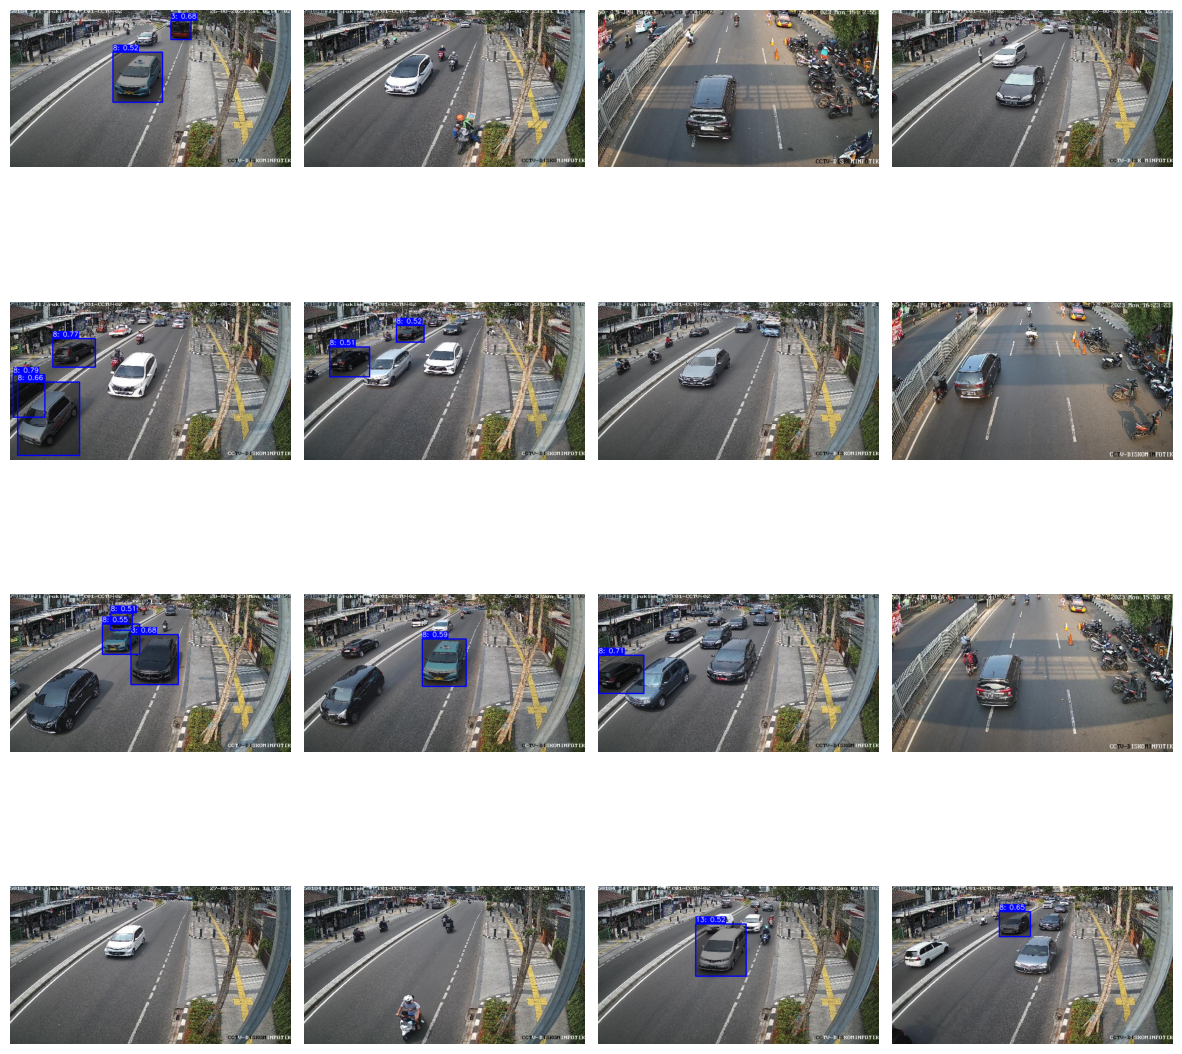

In [ ]:
import os
import random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the inference + drawing function ---
def infer_image(
    model,
    img_path: str,
    device,
    category_names: list,
    score_thresh: float = 0.5,
    alpha: float = 0.4
):
    """
    Run Faster R-CNN on a single image, draw semi-transparent fill, then
    draw boxes + label:score on the final image.
    """
    # load & preprocess
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    tensor  = torch.from_numpy(img_rgb/255.).permute(2,0,1).float().to(device)

    # inference
    model.eval()
    with torch.no_grad():
        outputs = model([tensor])[0]

    boxes  = outputs['boxes'].cpu().numpy()
    scores = outputs['scores'].cpu().numpy()
    labels = outputs['labels'].cpu().numpy()

    # overlay for semi-transparent fill
    overlay = img_rgb.copy()
    for box, score in zip(boxes, scores):
        if score < score_thresh: continue
        x1,y1,x2,y2 = box.astype(int)
        cv2.rectangle(overlay, (x1,y1), (x2,y2), (0,0,0), -1)

    annotated = cv2.addWeighted(overlay, alpha, img_rgb, 1-alpha, 0)

    # draw borders + labels
    for box, score, label in zip(boxes, scores, labels):
        if score < score_thresh: continue
        x1,y1,x2,y2 = box.astype(int)
        name = category_names[label] if label < len(category_names) else str(label)
        text = f"{name}: {score:.2f}"

        # border
        cv2.rectangle(annotated, (x1,y1), (x2,y2), (0,0,255), 2)

        # text background
        (tw, th), baseline = cv2.getTextSize(text,
                                             cv2.FONT_HERSHEY_SIMPLEX,
                                             0.5, 1)
        cv2.rectangle(annotated,
                      (x1, y1-th-baseline),
                      (x1+tw, y1),
                      (0,0,255), -1)

        # text
        cv2.putText(annotated, text,
                    (x1, y1-baseline),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255,255,255), 1,
                    lineType=cv2.LINE_AA)

    return annotated

# --- 2. Sample 16 random test images and plot ---
custom_image_dir = '/content/drive/MyDrive/Projects/Car Detection v2/Multi Class Data/test/images'
image_files = [f for f in os.listdir(custom_image_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]

selected_images = random.sample(image_files, 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, img_file in enumerate(selected_images):
    row, col = divmod(i, 4)
    img_path = os.path.join(custom_image_dir, img_file)
    detected = infer_image(
        model=model,
        img_path=img_path,
        device=device,
        category_names=['__background__','car'],  # adjust as needed
        score_thresh=0.5,
        alpha=0.4
    )
    axes[row, col].imshow(detected)
    axes[row, col].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


## 10. Video Inference

In [ ]:
# --- 2. VIDEO INFERENCE & EXPORT ---
def process_video(model, in_path, out_path, device, score_thresh=0.5, alpha=0.4, print_every=30):
    """
    Reads in_path, runs detection frame by frame, draws masks+boxes,
    and writes the result to out_path.
    """
    cap   = cv2.VideoCapture(in_path)
    fps   = int(cap.get(cv2.CAP_PROP_FPS))
    w     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc= cv2.VideoWriter_fourcc(*'mp4v')
    writer= cv2.VideoWriter(out_path, fourcc, fps, (w,h))

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # convert BGR→RGB & to tensor
        rgb    = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        tensor = torch.from_numpy(rgb/255.).permute(2,0,1).float().to(device)

        # inference
        with torch.no_grad():
            out = model([tensor])[0]

        boxes  = out['boxes'].cpu().numpy()
        scores = out['scores'].cpu().numpy()

        overlay = rgb.copy()
        for box, score in zip(boxes, scores):
            if score < score_thresh:
                continue
            x1,y1,x2,y2 = box.astype(int)
            cv2.rectangle(overlay, (x1,y1), (x2,y2), (0,0,0), -1)
            cv2.rectangle(rgb,     (x1,y1), (x2,y2), (0,0,255), 2)

        # blend & convert back to BGR for writer
        blended = cv2.addWeighted(overlay, alpha, rgb, 1-alpha, 0)
        out_bgr = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        writer.write(out_bgr)

        frame_idx += 1
        if frame_idx % print_every == 0:
            print(f"[Frame {frame_idx}] processed.")

    cap.release()
    writer.release()
    print("Video saved to:", out_path)


In [ ]:
import cv2
import torch

def process_video(model,
                  in_path,
                  out_path,
                  device,
                  category_names,
                  score_thresh=0.5,
                  alpha=0.4,
                  print_every=30):
    """
    Reads in_path, runs detection frame by frame, draws masks+boxes+labels,
    and writes the result to out_path.

    Args:
        model: a detection model returning dicts with 'boxes', 'labels', 'scores'
        in_path: input video file
        out_path: output video file
        device: torch.device
        category_names: list of class names, e.g. ["__background__", "car"]
        score_thresh: minimum confidence
        alpha: blending factor for overlay
        print_every: how often to log progress
    """
    cap    = cv2.VideoCapture(in_path)
    fps    = int(cap.get(cv2.CAP_PROP_FPS))
    w      = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # BGR→RGB & to tensor
        rgb    = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        tensor = torch.from_numpy(rgb / 255.0).permute(2, 0, 1).float().to(device)

        # inference
        with torch.no_grad():
            out = model([tensor])[0]

        boxes  = out['boxes'].cpu().numpy()
        labels = out['labels'].cpu().numpy()
        scores = out['scores'].cpu().numpy()

        overlay = rgb.copy()
        for box, label, score in zip(boxes, labels, scores):
            if score < score_thresh:
                continue

            x1, y1, x2, y2 = box.astype(int)
            class_name    = category_names[label]
            text          = f"{class_name}: {score:.2f}"

            # draw a semi-transparent fill under the box
            # cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 0, 0), -1)
            # draw the box border
            cv2.rectangle(rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)
            # draw the text on the rgb frame (above the box)
            cv2.putText(rgb,
                        text,
                        (x1, max(y1 - 10, 0)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 255, 255),
                        2,
                        lineType=cv2.LINE_AA)

        # blend & convert back to BGR for writing
        blended = cv2.addWeighted(overlay, alpha, rgb, 1 - alpha, 0)
        out_bgr = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        writer.write(out_bgr)

        frame_idx += 1
        if frame_idx % print_every == 0:
            print(f"[Frame {frame_idx}] processed.")

    cap.release()
    writer.release()
    print("Video saved to:", out_path)


In [ ]:
# Make sure your model is on the right device and in eval mode
model.to(device)
model.eval()

# Paths to your input & output videos
input_video_path  = '/content/drive/MyDrive/Projects/Car Detection v2/Video Test/traffic_test.mp4'
output_video_path = '/content/drive/MyDrive/Projects/Car Detection v2/Video Test Prediction Colab Env/multiclass_colab_Faster-RCNN_50epochs.mp4'
category_names = ["__background__", "car"]

# Run the video through your Faster R-CNN
process_video(
    model,
    in_path    = input_video_path,
    out_path   = output_video_path,
    device     = device,
    score_thresh = 0.5,   # only draw boxes with score ≥ 0.5
    alpha        = 0.4,   # overlay transparency
    print_every  = 30,     # log every 30 frames
    category_names=category_names
)